In [16]:
!pip install shap==0.39.0

Looking in indexes: https://pypi.org/simple, https://packagecloud.io/github/git-lfs/pypi/simple
     |████████████████████████████████| 356 kB 4.5 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=544955 sha256=6c4ddc20722a8ec91961a7d26d8d8904eaf350944b14f1431abe0d58cf0c32e4
  Stored in directory: /home/isadorasalles/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap
  Attempting uninstall: shap
    Found existing installation: shap 0.42.1
    Uninstalling shap-0.42.1:
      Successfully uninstalled shap-0.42.1
You should consider upgrading via the '/home/isadorasalles/anaconda3/bin/python3 -m pip install --upgrade pip' command.


In [1]:
# Useful imports and setup
import sys
import os
# Necessary to import code from ../scripts/
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    
import warnings
warnings.filterwarnings("ignore")
    
import random
random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import operator
from sklearn.preprocessing import MinMaxScaler
import shap
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

from preprocessing import preprocess
from cluster import *
from baseline import train_val_split, baseline_model, train_model, print_metrics

%load_ext autoreload
%autoreload 2

MODEL_PATH = '../models/saved/'
labels_path = '../labels/'
data_path = '../data/'
results_path = '../results/shap/'
clustering_method = 'spectral_clustering'
labels_cluster_path = labels_path + clustering_method + '/'
course = 'dsp_001'
path = data_path + course + '/'
feature_types = ['lalle_conati', 'boroujeni_et_al', 'chen_cui', 'marras_et_al']
metadata = pd.read_csv(data_path + 'metadata.csv')
hard_fail = path + 'feature_labels.csv'
percentile = 0.6

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
x_train, x_test, x_val, y_train, y_test, y_val, feature_names, patterns = preprocess(course, path, percentile, feature_types, metadata, hard_fail)

In [3]:
# Concat features & labels
X = np.concatenate([x_train, x_val, x_test], axis=0)
Y = np.concatenate([y_train, y_val, y_test], axis=0)

In [4]:
labels = np.loadtxt(labels_cluster_path+'baseline_cluster_labels_perc_0.6_gamma_0.6.txt', dtype=int)

In [5]:
df_0 = pd.read_csv('../results/lime/'+clustering_method+'/lime_cluster_0.csv', index_col=0)

In [6]:
instances_0 = df_0['exp number'].tolist()

In [22]:
def get_instance_explanations(c, instances):
    idx = np.where(labels == c)[0]
    X_train = X[idx]
    Y_train = Y[idx]
    x_train, x_val, y_train, y_val = train_val_split(X_train, Y_train)

    baseline_params = {
    'name': 'baseline-32u-1l',
    'optimizer': 'adam',
    'loss': 'binary_crossentropy',
    'metrics': ['binary_accuracy'],
    'epochs': 20,
    'batch_size': 64,
    'verbose': 1
    }
    baseline = baseline_model()

    baseline.load_weights(MODEL_PATH + 'baseline_classifier_for_cluster_'+str(c))

    baseline.predict(x_train)
    explainer = shap.DeepExplainer(baseline, x_train)

    shap_values = explainer.shap_values(x_train[instances])
    
    shap_mean_values = []
    shap_mean_values.append(np.mean(shap_values[0], axis=1))
    
    return explainer, shap_values, shap_mean_values, instances, y_train

def get_feature_importance(shap_mean_values):

    feature_type_mean_importance = {}

    for i in range(len(feature_names)):
        d = pd.DataFrame({i: np.absolute(shap_mean_values[0][:, i])})
        feature_type_mean_importance[feature_names[i]] = np.mean(d[i])
 
    return dict(sorted(feature_type_mean_importance.items(), key=operator.itemgetter(1),reverse=True))

Getting explanations for cluster 0


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


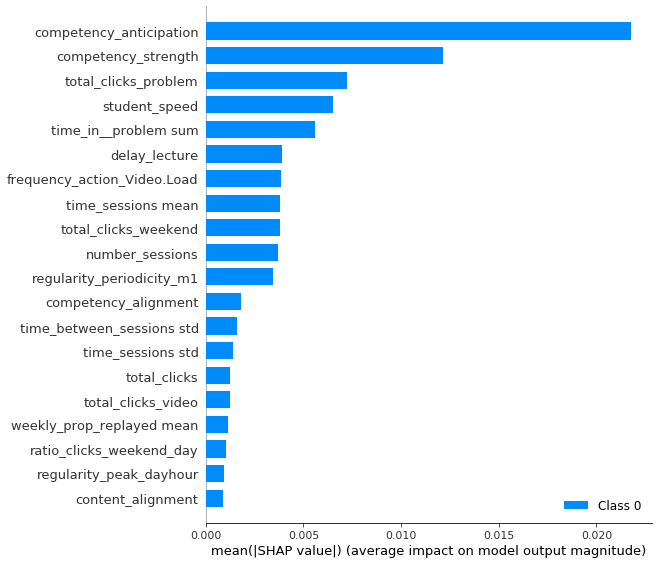

Getting explanations for cluster 1


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


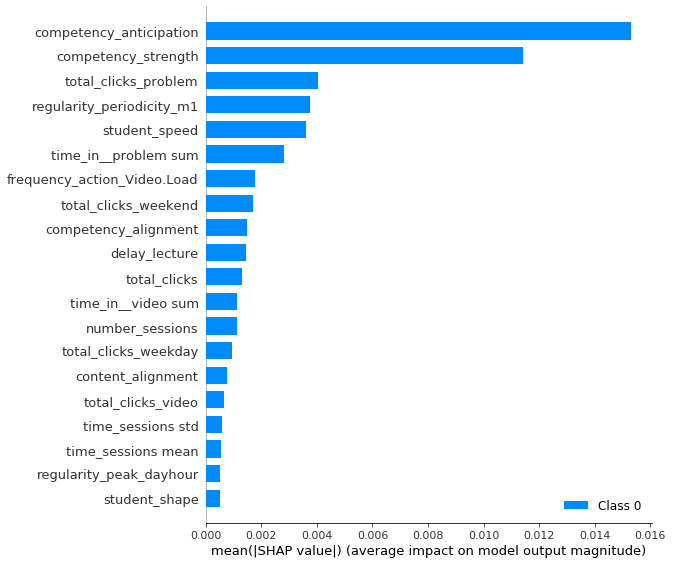

Getting explanations for cluster 2


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


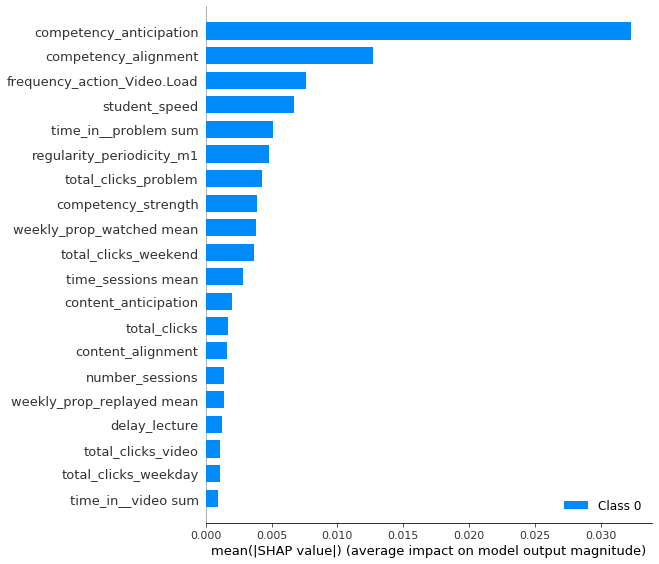

Getting explanations for cluster 3


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


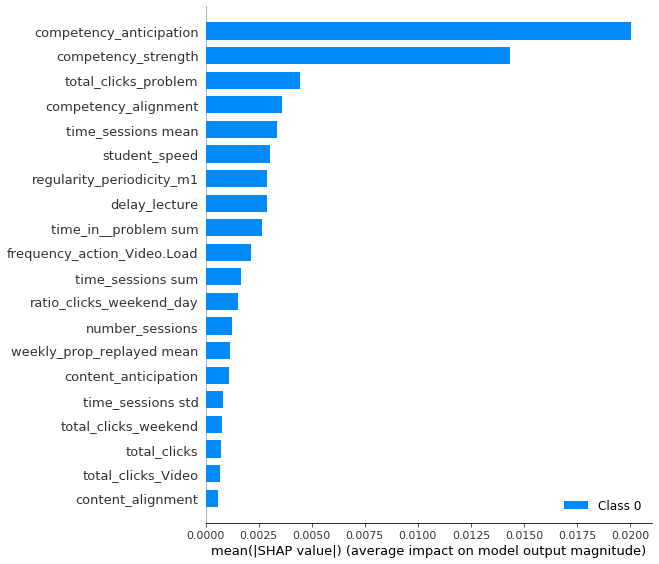

In [24]:
df_importance = pd.DataFrame()
for c in np.unique(labels):
    print("Getting explanations for cluster {0}".format(c))
    df = pd.read_csv('../results/lime/'+clustering_method+'/lime_cluster_'+str(c)+'.csv', index_col=0)
    instances = df['exp number'].tolist()
    explainer, shap_values, shap_mean_values, instances, y_train = get_instance_explanations(c, instances)
    shap.summary_plot(shap_mean_values, feature_names=feature_names)
        
    aux = pd.DataFrame(get_feature_importance(shap_mean_values), index=[c])
    df_importance = pd.concat([df_importance, aux])

In [28]:
shap.initjs()
shap.force_plot(
    explainer.expected_value[0], shap_values[0][0], feature_names=feature_names
)

In [26]:
path = results_path + clustering_method + '/'
if not os.path.exists(path):
    os.makedirs(path)

In [27]:
df_importance.to_csv(path+'features_importance.csv', index=False)